In [4]:
import cv2

In [5]:
# Import required libraries
from os import listdir
from os.path import isfile, join
import numpy as np
from matplotlib import pyplot as plt
import glob
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from numpy import *
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_learning_curves
from mlxtend.preprocessing import shuffle_arrays_unison

In [6]:
# read labels dataset
labels_df = pd.read_csv("labels_df")

In [7]:
# read sample of images from training dataset (obtained from Kaggle website) and extract pixels FROM IMAGES
image_filenames = glob.glob("tiff_images/train-tif-v2/*.tif")[0:300]
X = np.array([np.array(cv2.imread(image)) for image in image_filenames])
print X.shape

(300, 256, 256, 3)


In [8]:
# reshape image data
pixels_X = X.flatten().reshape(X.shape[0], -1)
print pixels_X

[[29 36 39 ..., 18 23 26]
 [11 17 19 ..., 11 17 18]
 [ 8 12 14 ...,  7 12 14]
 ..., 
 [11 16 18 ..., 12 17 20]
 [ 8 13 16 ..., 17 20 22]
 [ 8 12 14 ...,  8 12 15]]


In [9]:
# create a list of labels (from the labels dataset) for sampled images 
y_labels = []
for image in image_filenames:
  image_name = image.rsplit('/',1)[1]
  image_name = image_name.rsplit('.',1)[0]
  y_labels.append(str(labels_df.loc[labels_df['image_name'] == image_name,'tags'].values[0]))

In [10]:
# create a dataframe from the list of labels for the sampled data
df_sample_labels = pd.DataFrame({'tags': y_labels})
df_sample_labels.to_csv("labels")

In [11]:
# create a list of the weather and land ('agriculture', 'primary', 'road', 'water', 
#                                    'bare_ground', 'cultivation', 'artisinal_mine''habitation', 
#                                    'slash_burn', 'conventional_mine', 'blooming', 'selective_logging')
# The image labels are combination of these labels.

label_list = []
for tag_str in df_sample_labels.tags.values:
  labels = tag_str.split(' ')
  for label in labels:
    if label not in label_list:
      label_list.append(label)
print label_list

['agriculture', 'partly_cloudy', 'primary', 'road', 'water', 'clear', 'haze', 'cloudy', 'bare_ground', 'cultivation', 'artisinal_mine', 'habitation', 'slash_burn', 'conventional_mine', 'blooming', 'selective_logging']


In [12]:
# assign numeric category or classes to each unique label in sample data
y_set = set(y_labels)
values_to_assign = list(range(1, len(y_set)+1))
values_y_set = dict(zip(list(y_set), values_to_assign))
y_data = ([values_y_set [n] if n in values_y_set else n for n in y_labels])
y_data  = np.array((y_data), dtype = np.int32)

In [ ]:
# Standardize the data
std_scale = preprocessing.StandardScaler().fit(pixels_X)
pixels_std_X = std_scale.transform(pixels_X)

In [14]:
# Principal Component Analysis
pca_std = PCA(n_components= 50).fit(pixels_std_X)

In [15]:
# PCA: first fifty principal components (which explain 98.27% of the variance in the data) were chosen for classification by SVM
var = pca_std.explained_variance_ratio_
var1 = np.cumsum(np.round(pca_std.explained_variance_ratio_, decimals = 4)*100)
print var1

[ 72.71  79.8   83.24  85.14  86.89  88.41  89.54  90.42  91.26  91.98
  92.53  93.05  93.5   93.89  94.24  94.57  94.83  95.09  95.31  95.52
  95.71  95.88  96.05  96.21  96.35  96.49  96.62  96.74  96.86  96.97
  97.07  97.17  97.26  97.35  97.44  97.52  97.6   97.67  97.74  97.8
  97.86  97.92  97.97  98.02  98.07  98.11  98.15  98.19  98.23  98.27]


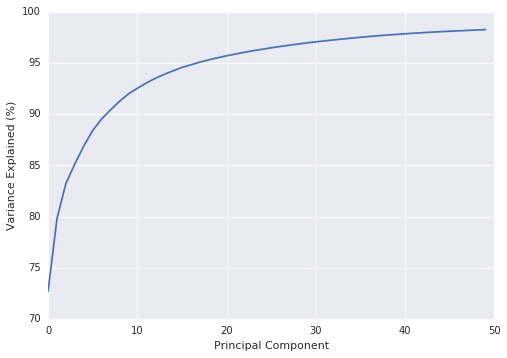

In [16]:
# Plot: shows the percentage of variance explained by the principal components
plt.plot(var1)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.savefig("pca.png", bbox_inches = "tight")

In [17]:
# PCA
X_std_pca = pca_std.transform(pixels_std_X)

In [18]:
# Split the standardized datset into training (285) and test dataset (15) 
X_train, X_test, y_train, y_test = train_test_split(X_std_pca, y_data, test_size = 0.05, random_state = 45)
print len(X_train)
print len(X_test)

285
15


In [19]:
# Classification: Support Vector Machine model (SVM). With Default values of parameters, the classification accuracy was 40% 
clf = SVC(random_state= 50)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.40000000000000002

In [20]:
# Predict labels for test dataset and compute accuracy score
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    y_pred = clf.predict(features)
    return (accuracy_score(target, y_pred))

In [ ]:
# Gridsearch to identify best combination of parameters for SVM model
# Create the parameters list you wish to tune
parameters = {'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 
             100, 1000, 10000, 40000], 'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Initialize the classifier
clf = SVC(random_state= 50)

# Make an f1 scoring function using 'make_scorer' 
acc_score = make_scorer(accuracy_score)

# Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, cv= 10, scoring=acc_score)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

In [23]:
print "Tuned model has a training accuracy score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing accuracy score of {:.4f}.".format(predict_labels(clf, X_test, y_test))
print ('Best C:', grid_obj.best_estimator_.C)
print ('Best Kernel:', grid_obj.best_estimator_.kernel)
print ('Best Gamma:', grid_obj.best_estimator_.gamma)

Tuned model has a training accuracy score of 0.7193.
Tuned model has a testing accuracy score of 0.5333.
('Best C:', 1)
('Best Kernel:', 'rbf')
('Best Gamma:', 0.0001)


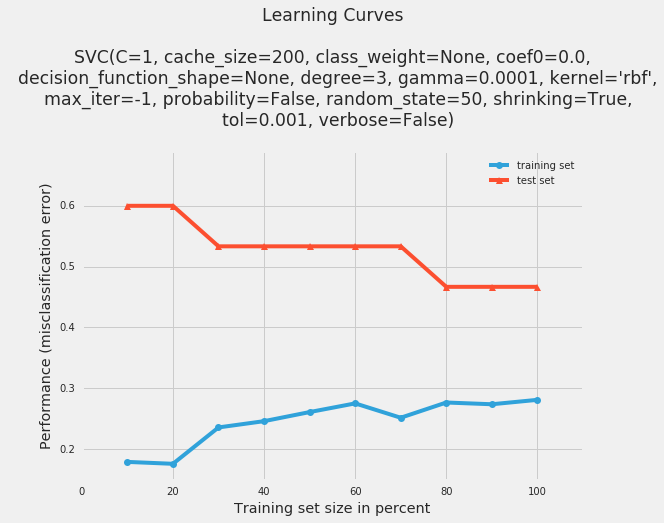

In [33]:
# plot learning curve
clf = SVC(random_state= 50, C= 1, kernel = 'rbf', gamma = 0.0001)
plot_learning_curves(X_train, y_train, X_test, y_test, clf)
plt.show()